# Introduction

The purpose of this hands-on session istwo-fold: 

 * Explaining how to evaluate a quasi-analytical solution, that is singular of the pressureless gas dynamics
 
 * Show that once the solution is becoming singular, the dynamics of the singularity is not the one of the original

# General setting and smooth solution

We consider the following Cauchy problem:

$\rho(t, \mathbf{x})$, $\mathbf{u}(t, \mathbf{x})$ satisfying

\begin{equation}
    \left\{
    \begin{aligned}
    \frac{\partial \rho}{\partial t} + \nabla \cdot (\rho \mathbf{u}) = 0 \\
    \frac{\partial \rho \mathbf{u}}{\partial t} + \nabla \cdot (\rho \mathbf{u} \mathbf{u} ) = 0
    \end{aligned}
    \right.
\end{equation}

with  $\rho(0, \mathbf{x}) = \rho_0(x) = 1$

\begin{equation}
    \left\{
        \begin{aligned}
            \mathbf{u}(0, x) = 0, \; x \in (-\infty, -1] \cup [-1, +\infty) \\
            \mathbf{u}(0, x) = 1 + x, \; x \in [-1, 0] \\
            \mathbf{u}(0, x) = 1 - x, \; x \in [0, 1]           
        \end{aligned}
    \right.    
\end{equation}

<IPython.core.display.Javascript object>


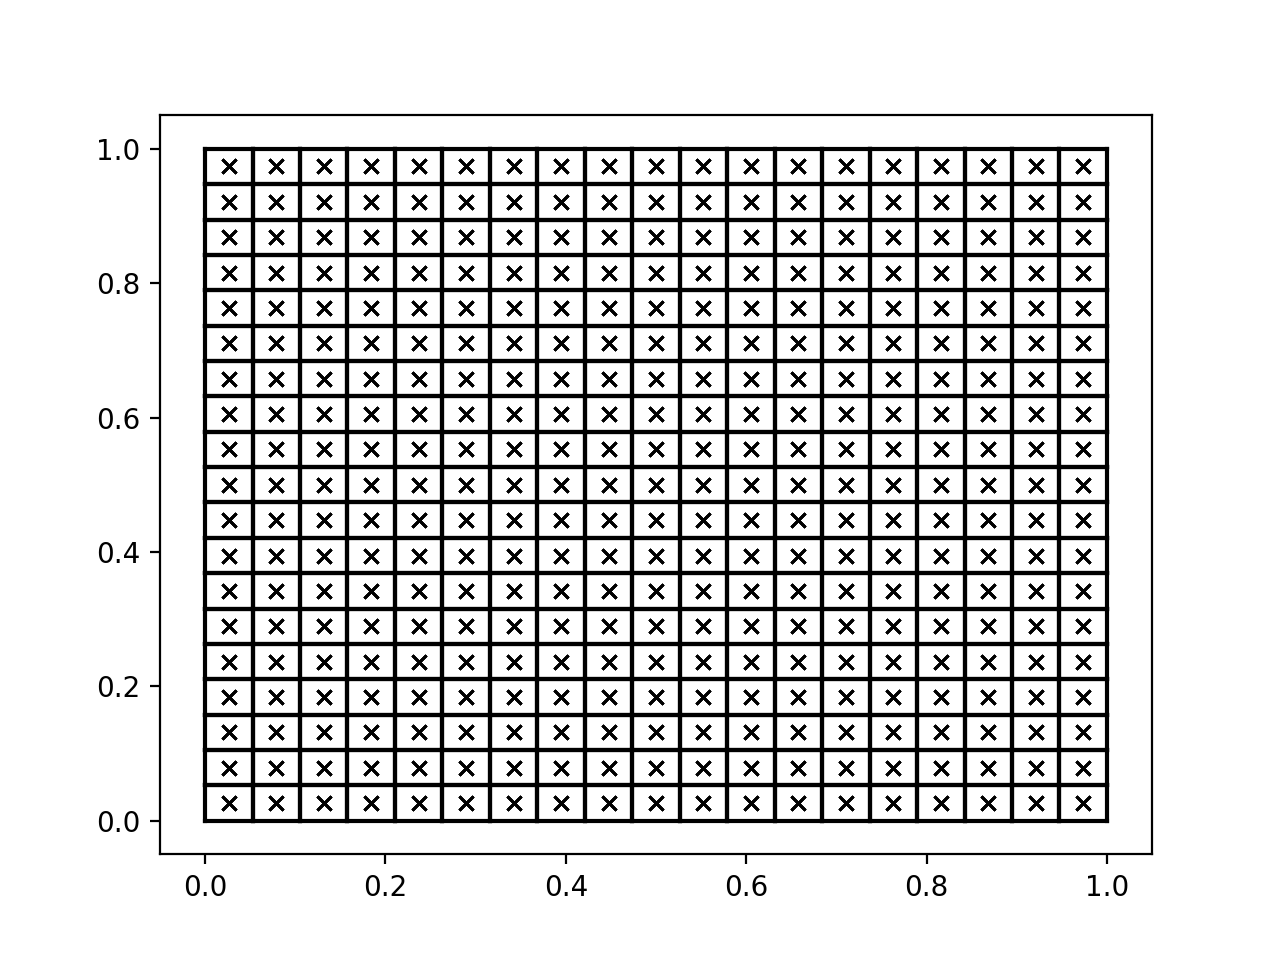

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt

from josie.geom import CircleArc, Line
from josie.mesh import Mesh
from josie.bc import make_periodic, Direction

left = Line([0, 0], [0, 1])
# bottom = CircleArc([0, 0], [1, 0], [0.2, 0.2])
bottom = Line([0, 0], [1, 0])
right = Line([1, 0], [1, 1])
top = Line([0, 1], [1, 1])

left, right = make_periodic(left, right, Direction.X)
bottom, top = make_periodic(bottom, top, Direction.Y)

mesh = Mesh(left, bottom, right, top)
mesh.interpolate(20, 20)
mesh.generate()

mesh.plot()
plt.show()



In [2]:
import numpy as np

from josie.solver import Problem, StateTemplate, State, Solver
from josie.mesh import Cell

class Advection(Problem):
    Q = StateTemplate("u")
    V = np.array([1, 0])
    
    @classmethod
    def flux(cls, Q: State) -> State:
        return cls.V*Q
    
    
def init(cell: Cell) -> State: 
    xc, yc = cell.centroid
    
    if xc > 0.45:
        return Advection.Q(1)
    else:
        return Advection.Q(0)
    

    
def upwind(cell):
    Q = solver.problem.Q(0)
    for neigh in cell:
        norm = neigh.face.normal
        flux = Advection.flux
        S = neigh.face.surface

        un = Advection.V.dot(norm)

        if un >= 0:
            Q = Q + flux(cell.value).dot(norm)*S
        else:
            Q = Q + flux(neigh.value).dot(norm)*S

    return Q


solver = Solver(mesh, Advection)
solver.init(init)



<IPython.core.display.Javascript object>


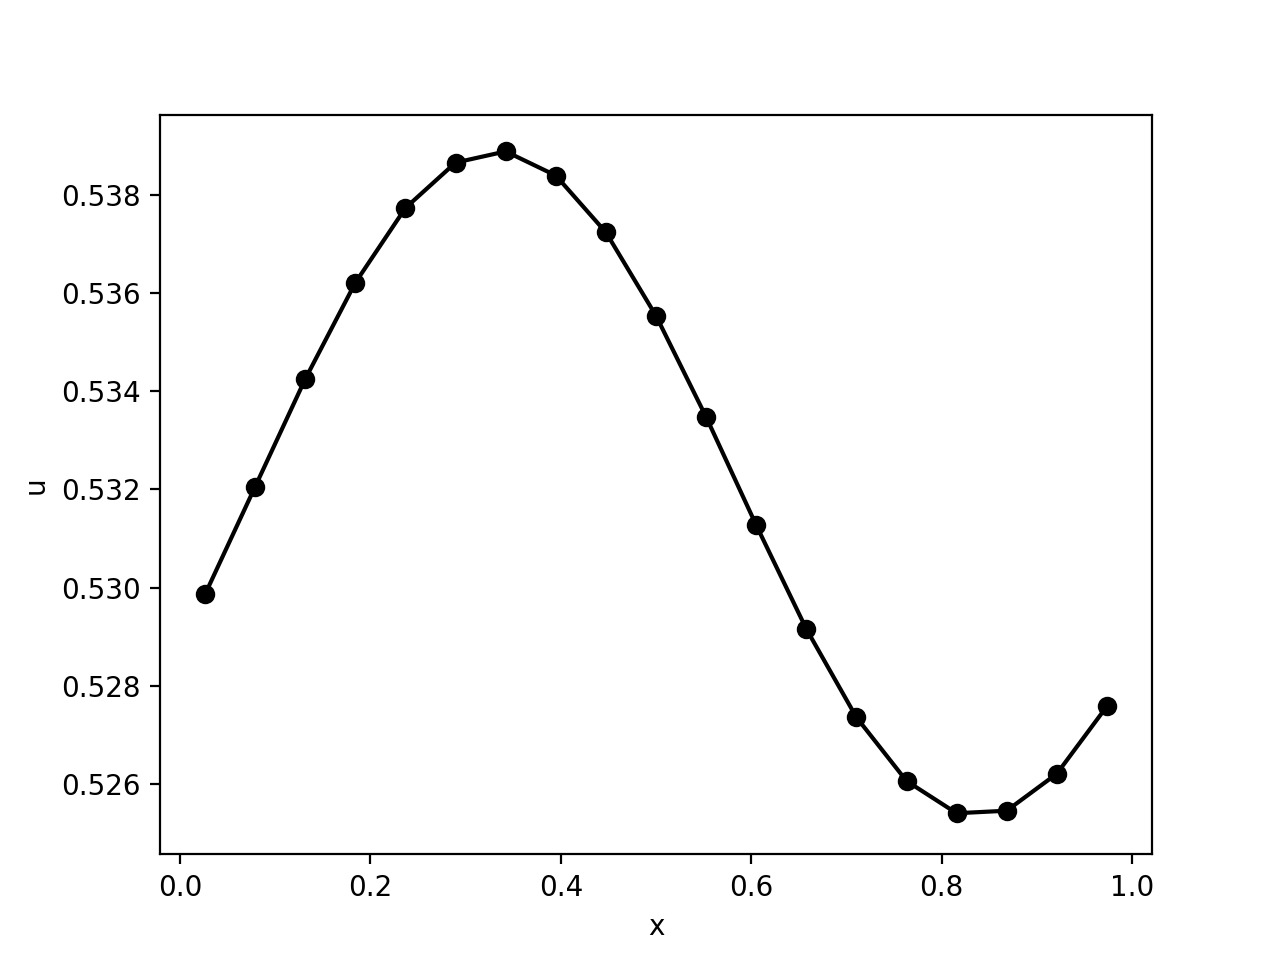

In [9]:
import matplotlib.animation as animation

dt = 0.01
fig = plt.figure()
plt.xlabel('x')
plt.ylabel('u')
ims = []
for i in range(100):
    solver.step(dt, upwind)
    
    # Pick one line
    data = [(np.array(cell.centroid), cell.value) for cell in solver.mesh.cells[:, -1]]
    data = np.asarray(data)  
    x = np.array([x  for x, y in data[:, 0] ])
    val = np.concatenate(data[:, 1])
    ims.append(plt.plot(x, val, 'ko-'))
    ani = animation.ArtistAnimation(fig, ims, interval=10)
ani
